# Chimeric Sequence HMM Analysis

## Installation of Libraries

In [27]:
!pip install biopython

In [28]:
import numpy as np
import random
import requests
import math
import matplotlib.pyplot as plt
from Bio import SeqIO
from io import StringIO

## Download genome sequences

In [29]:
def download_fasta(ac):
    """
    Download the FASTA file from the ENA API given an accession.
    """
    url = f"https://www.ebi.ac.uk/ena/browser/api/fasta/{ac}"
    response = requests.get(url)
    if response.status_code == 200:
        fasta_str = response.text
        # Parse the fasta using BioPython
        fasta_io = StringIO(fasta_str)
        record = list(SeqIO.parse(fasta_io, "fasta"))[0]
        return str(record.seq).upper()
    else:
        raise Exception(f"Error downloading {ac}: {response.status_code}")

In [30]:
# Select genomes with very different GC content:
# Deinococcus radiodurans (AC: CP015081.1, ~67.1% GC)
# Clostridium botulinum (AC: CP002410.1, ~28.5% GC)
ac1 = "CP015081.1"
ac2 = "CP002410.1"

print("Downloading genome sequences...")
seq1 = download_fasta(ac1)
seq2 = download_fasta(ac2)
print("Download complete.")
print(f"Genome 1 length: {len(seq1)}")
print(f"Genome 2 length: {len(seq2)}")

Download complete.
Genome 1 length: 2646742
Genome 2 length: 2773157


## Create a Chimeric Sequence

In [31]:
def get_random_piece(sequence, avg_length=300):
    """
    Select a random piece from the given sequence.
    The length is drawn from an exponential distribution with mean avg_length.
    Ensure the piece contains only A, T, G, C.
    """
    # Sample a length from an exponential distribution.
    # np.random.exponential returns a float; we convert to int and enforce at least length 1.
    piece_length = max(1, int(np.random.exponential(avg_length)))
    max_start = len(sequence) - piece_length
    if max_start < 0:
        return None  # piece cannot be taken if sequence is too short
    # Try a few times to get a valid piece (i.e., no ambiguous letters)
    for _ in range(50):
        start = random.randint(0, max_start)
        piece = sequence[start: start+piece_length]
        if all(letter in "ATGC" for letter in piece):
            return piece
    return None  # if 50 tries fail, return None

In [32]:
def build_chimeric_sequence(target_length=50000, avg_length=300):
    """
    Build a chimeric sequence of target_length by concatenating pieces randomly sampled
    from genome1 and genome2 with equal probability.
    Returns the chimeric sequence and a parallel list of true states ('1' for genome1, '2' for genome2).
    """
    chimeric_seq = ""
    true_states = ""
    # Continue to add pieces until target length is exceeded.
    while len(chimeric_seq) < target_length:
        # Randomly select one genome (state '1' or '2')
        state = random.choice(['1', '2'])
        if state == '1':
            piece = get_random_piece(seq1, avg_length)
        else:
            piece = get_random_piece(seq2, avg_length)
        if piece is None:
            continue
        # Append the piece and annotate its source state.
        chimeric_seq += piece
        true_states += state * len(piece)
    # Trim to exact target length if overshot.
    chimeric_seq = chimeric_seq[:target_length]
    true_states = true_states[:target_length]
    return chimeric_seq, true_states

In [33]:
print("Building chimeric sequence...")
chimeric_sequence, chimeric_true_states = build_chimeric_sequence(target_length=50000, avg_length=300)
print(f"Chimeric sequence length: {len(chimeric_sequence)}")

Building chimeric sequence...
Chimeric sequence length: 50000


## Compute Genome Emission Probabilities

In [34]:
def compute_emission_probs(sequence):
    """
    Given a nucleotide sequence (assumed to contain only A, T, G, C),
    compute the frequencies of A+T and G+C and then determine the emission probabilities
    so that the probability for A and T are each half the A+T frequency
    and for G and C are each half the G+C frequency.
    """
    total = len(sequence)
    count_A = sequence.count("A")
    count_T = sequence.count("T")
    count_G = sequence.count("G")
    count_C = sequence.count("C")
    at_freq = (count_A + count_T) / total
    gc_freq = (count_G + count_C) / total
    probs = {
        "A": at_freq / 2,
        "T": at_freq / 2,
        "G": gc_freq / 2,
        "C": gc_freq / 2,
    }
    return probs

# Compute emission probabilities for each genome
emission_probs_1 = compute_emission_probs(seq1)
emission_probs_2 = compute_emission_probs(seq2)

print("Emission probabilities:")
print("Genome 1:", emission_probs_1)
print("Genome 2:", emission_probs_2)

Emission probabilities:
Genome 1: {'A': 0.164633160315588, 'T': 0.164633160315588, 'G': 0.335366839684412, 'C': 0.335366839684412}
Genome 2: {'A': 0.3575517001020858, 'T': 0.3575517001020858, 'G': 0.1424482998979142, 'C': 0.1424482998979142}


## Define HMM Model and the Viterbi Algorithm

In [35]:
# Define states and transition probabilities.
# For an average run-length of 300, self-transition probability is 299/300.
import math

p_stay = 299 / 300
p_switch = 1 / 300

states = ['1', '2']
transition_probs = {
    '1': {'1': p_stay, '2': p_switch},
    '2': {'1': p_switch, '2': p_stay},
}

# Assume equal start probabilities.
start_probs = {
    '1': 0.5,
    '2': 0.5,
}

In [36]:
def viterbi(obs_seq, states, start_p, trans_p, emis_p_1, emis_p_2):
    """
    Viterbi algorithm using log probabilities.
    obs_seq: observed sequence (string of A, T, G, C)
    states: list of states labels, e.g., ['1', '2']
    start_p: dictionary of starting probabilities.
    trans_p: transition probability dictionary.
    emis_p_1 and emis_p_2: emission probability dictionaries for state 1 and 2.
    Returns the most likely state path as a string of labels.
    """
    n = len(obs_seq)
    V = {}  # V[state][pos] = log probability of best path ending with state at pos
    path = {}

    # Initialization
    for state in states:
        emis = emis_p_1 if state == '1' else emis_p_2
        V[state] = [math.log(start_p[state]) + math.log(emis[obs_seq[0]])]
        path[state] = [state]

    # Recursion
    for t in range(1, n):
        new_V = {}
        new_path = {}
        symbol = obs_seq[t]
        for curr_state in states:
            emis = emis_p_1 if curr_state == '1' else emis_p_2
            (prob, prev_state) = max(
                (V[prev_state][t-1] + math.log(trans_p[prev_state][curr_state]) + math.log(emis[symbol]), prev_state)
                for prev_state in states
            )
            new_V[curr_state] = V[curr_state] + [prob] if curr_state in V else [prob]
            new_path[curr_state] = path[prev_state] + [curr_state]
        for s in states:
            V[s].append(new_V[s][-1])
            path[s] = new_path[s]

    # Termination: choose the final state with highest probability.
    final_state = max(states, key=lambda s: V[s][-1])
    return "".join(path[final_state])

In [37]:
def viterbi_decoding(obs_seq, states, start_p, trans_p, emis_p_1, emis_p_2):
    """
    A wrapper for the viterbi algorithm.
    """
    # Instead of building V as dictionary of lists from scratch, we implement a simpler version.
    n = len(obs_seq)
    # Initialize matrices for probabilities and backpointers
    viterbi_mat = {s: [float('-inf')] * n for s in states}
    backpointer = {s: [None] * n for s in states}

    # Initialization
    for s in states:
        emis = emis_p_1 if s == '1' else emis_p_2
        viterbi_mat[s][0] = math.log(start_p[s]) + math.log(emis[obs_seq[0]])

    # Recursion
    for t in range(1, n):
        symbol = obs_seq[t]
        for s in states:
            emis = emis_p_1 if s == '1' else emis_p_2
            max_tr_prob = float('-inf')
            prev_state_selected = None
            for s_prev in states:
                tr_prob = viterbi_mat[s_prev][t-1] + math.log(trans_p[s_prev][s])
                if tr_prob > max_tr_prob:
                    max_tr_prob = tr_prob
                    prev_state_selected = s_prev
            viterbi_mat[s][t] = max_tr_prob + math.log(emis[symbol])
            backpointer[s][t] = prev_state_selected

    # Termination
    final_state = None
    max_prob = float('-inf')
    for s in states:
        if viterbi_mat[s][-1] > max_prob:
            max_prob = viterbi_mat[s][-1]
            final_state = s

    # Path backtracking
    best_path = [final_state]
    for t in range(n-1, 0, -1):
        best_path.insert(0, backpointer[best_path[0]][t])
    return "".join(best_path)


In [38]:
# For clarity, we now define a function that wraps Viterbi decoding.
def decode_sequence(observed_seq):
    return viterbi_decoding(observed_seq, states, start_probs, transition_probs,
                              emission_probs_1, emission_probs_2)

## Apply HMM to the Sequences and Evaluate

In [39]:
def calculate_error_rate(true_states, predicted_states):
    """
    Calculate percentage of positions where true state does not match predicted state.
    """
    errors = sum(1 for t, p in zip(true_states, predicted_states) if t != p)
    return (errors / len(true_states)) * 100

# (a) Apply to the chimeric sequence
print("\nDecoding the chimeric sequence...")
predicted_states_chimeric = decode_sequence(chimeric_sequence)
error_chimeric = calculate_error_rate(chimeric_true_states, predicted_states_chimeric)
print(f"Chimeric sequence error rate: {error_chimeric:.2f}%")

# Save the predicted state sequence for the chimeric sequence to a file.
with open("predicted_states_chimeric.txt", "w") as f:
    f.write(predicted_states_chimeric)
print("Predicted state sequence for the chimeric sequence saved to 'predicted_states_chimeric.txt'.")


Decoding the chimeric sequence...
Chimeric sequence error rate: 2.85%
Predicted state sequence for the chimeric sequence saved to 'predicted_states_chimeric.txt'.


In [40]:
# Apply to parts of the original genomes (pure state)
# For each genome, take a segment of 10000 nucleotides (ensuring only ATGC letters) and decode.
def get_clean_segment(sequence, seg_length=50000):
    # Find a segment free of ambiguous letters.
    for i in range(0, len(sequence) - seg_length, seg_length//10):
        seg = sequence[i:i+seg_length]
        if all(letter in "ATGC" for letter in seg):
            return seg
    return None

seg1 = get_clean_segment(seq1, 50000)
seg2 = get_clean_segment(seq2, 50000)

if seg1 is None or seg2 is None:
    raise Exception("Could not find a sufficiently long clean segment in one of the genomes.")

print("\nDecoding pure genome segments...")
predicted_seg1 = decode_sequence(seg1)
predicted_seg2 = decode_sequence(seg2)

# For genome segments the true state is uniform.
true_seg1 = "1" * len(seg1)
true_seg2 = "2" * len(seg2)

error_seg1 = calculate_error_rate(true_seg1, predicted_seg1)
error_seg2 = calculate_error_rate(true_seg2, predicted_seg2)

print(f"Genome 1 segment error rate: {error_seg1:.2f}%")
print(f"Genome 2 segment error rate: {error_seg2:.2f}%")


Decoding pure genome segments...
Genome 1 segment error rate: 0.29%
Genome 2 segment error rate: 1.52%


## Visualizations

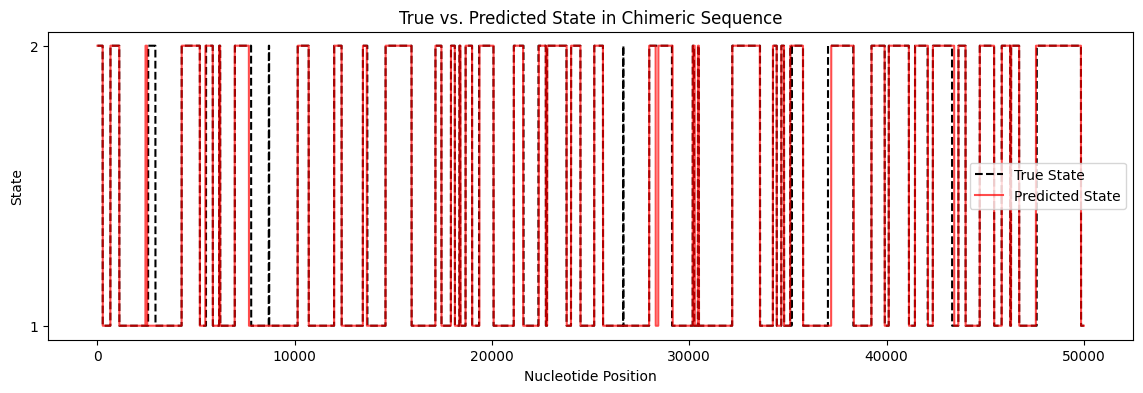

In [41]:
# Plot a segment of the chimeric sequence: True vs. Predicted States.
segment_length = 50000
chimeric_true_seg = chimeric_true_states[:segment_length]
predicted_states_seg = predicted_states_chimeric[:segment_length]
true_numeric = [int(state) for state in chimeric_true_seg]
pred_numeric = [int(state) for state in predicted_states_seg]

plt.figure(figsize=(14, 4))
plt.plot(true_numeric, label="True State", color="black", linestyle="--")
plt.plot(pred_numeric, label="Predicted State", color="red", alpha=0.7)
plt.xlabel("Nucleotide Position")
plt.ylabel("State")
plt.title("True vs. Predicted State in Chimeric Sequence")
plt.legend()
plt.yticks([1, 2])
plt.show()

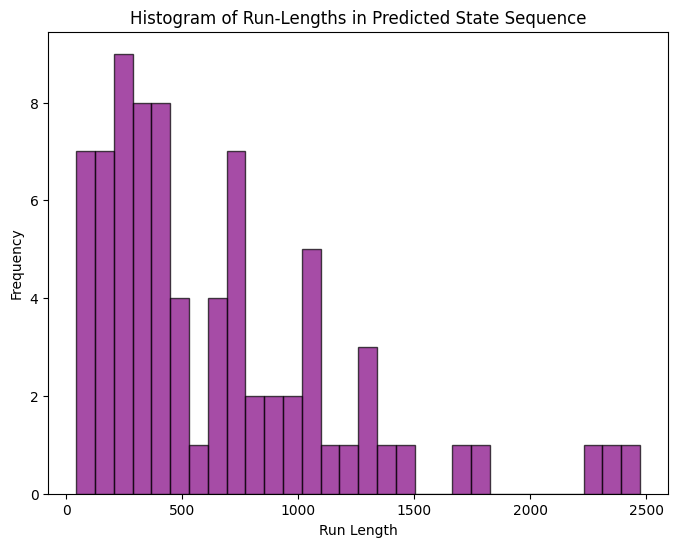

In [42]:
# Histogram of run-lengths in the predicted state sequence.
def get_run_lengths(state_seq):
    """
    Get the list of consecutive run lengths (number of consecutive identical states).
    """
    if not state_seq:
        return []
    runs = []
    current_run = 1
    for prev, curr in zip(state_seq[:-1], state_seq[1:]):
        if curr == prev:
            current_run += 1
        else:
            runs.append(current_run)
            current_run = 1
    runs.append(current_run)
    return runs

run_lengths = get_run_lengths(predicted_states_chimeric)
plt.figure(figsize=(8, 6))
plt.hist(run_lengths, bins=30, color="purple", edgecolor="black", alpha=0.7)
plt.xlabel("Run Length")
plt.ylabel("Frequency")
plt.title("Histogram of Run-Lengths in Predicted State Sequence")
plt.show()

## Conclusions

In [43]:
print("1. The chimeric sequence, composed of mixed segments from two genomes with very different GC contents, showed an error rate of"
      f" {error_chimeric:.2f}% when decoded with the Viterbi algorithm. This reflects the challenge of state transitions.")
print("2. The pure genome segments (expected to be in one state) showed much lower error rates, suggesting that the model "
      "accurately captures the emission distributions for long homogeneous segments.")
print("3. The transition probability (with an expected run length of 300) appears to be well suited for longer segments, but "
      "the performance may degrade near the boundaries between segments in the chimeric sequence.")

1. The chimeric sequence, composed of mixed segments from two genomes with very different GC contents, showed an error rate of 2.85% when decoded with the Viterbi algorithm. This reflects the challenge of state transitions.
2. The pure genome segments (expected to be in one state) showed much lower error rates, suggesting that the model accurately captures the emission distributions for long homogeneous segments.
3. The transition probability (with an expected run length of 300) appears to be well suited for longer segments, but the performance may degrade near the boundaries between segments in the chimeric sequence.
